# GHCN Cluster Analysis 
David Yerrington, 2021

This notebook will cover the potential to model weather data from a single station using unsupervised clustering methods using both dimesionality reduction and a reference prototype to explore weather events.  This notebook will examine the weather observations and propose a method for a clustering visual that groups similar groups of values together in a lower dimensional space.

### Meteorological Station Hailar, China

This region of China is known for having unpredictable and volatile weather patterns in additon to a high frequency of extreme events related to cold weather.  Perhaps this process can be useful in other data science problems and future pipelines for exploration.

> Hailar has a humid continental climate (Köppen Dwb) bordering on a subarctic climate (Köppen Dwc). Winters are long, very dry and severe, due to the semi−permanent Siberian High, while summers are short, though very warm, and rather wet, due to the East Asian monsoon. The monthly 24-hour average temperature ranges from −24.8 °C (−12.6 °F) in January to 20.4 °C (68.7 °F) in July, while the annual mean is −0.40 °C (31.3 °F). With monthly percent possible sunshine ranging from 55% in December to 69% in February, sunshine is abundant year-round, and the annual total is 2,719 hours. More than two-thirds of the annual rainfall occurs during the three summer months. The Mohe-Huma-Hailar triangle between northern Heilongjiang and Northeastern Inner Mongolia, which almost equivalent to China's subarctic climate zone, suffers the most severe cold winter in China. Hailar's extreme temperatures ranges from −48.2 to 37.7 °C (−54.8 to 99.9 °F). -[Wikipedia](https://en.wikipedia.org/wiki/Hailar_District#Climate)

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/ChinaHulunbuirHailar.png">


- Meteorological Station Name: Hailar
- Meteorological Station ID: CHM00050527
- Country Name: China
- Country Code: CH
- Historical Country Code: CI
- Elevation of the station (in meters): 650.0
- Latitude in decimal degrees: 49.2500
- Longitude in decimal degrees: 119.7000

## Library Imports

In [163]:
import pandas as pd, numpy as np
import altair as alt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')

%matplotlib inline

## Variables with good coverage

Min/Max Temperature(C) and percipitation are good between 1951 to current.  Snowdepth is available between 1978 - current.

In [18]:
%%time 

sql = f"""
SELECT * 
FROM bigquery-public-data.ghcn_d.ghcnd_inventory
WHERE id = 'CHM00050527'
"""

inventory = pd.read_gbq(sql, project_id="yerrington").set_index("element")

CPU times: user 68.7 ms, sys: 11.9 ms, total: 80.6 ms
Wall time: 2.37 s


### Load Descriptors
It looks like 4 major varialbes are availalbe for us to use with good coverage.

In [24]:
descriptors = pd.read_csv('../data/processed/ghcn_descriptors.csv', encoding="utf8").set_index('element')

In [25]:
inventory.join(descriptors)

,id,latitude,longitude,firstyear,lastyear,description
element,,,,,,
TMAX,CHM00050527,49.25,119.7,1951,2021,Maximum temperature (tenths of degrees C)
TMIN,CHM00050527,49.25,119.7,1951,2021,Minimum temperature (tenths of degrees C)
PRCP,CHM00050527,49.25,119.7,1951,2021,Precipitation (tenths of mm)
SNWD,CHM00050527,49.25,119.7,1978,2021,Snow depth (mm)
TAVG,CHM00050527,49.25,119.7,1951,2021,Average temperature (tenths of degrees C) [Not...


### Weather Observations
- MFLAG = H, based on highest hourly temperature
- QFLAG = ?, if a particular metric failed against the data.  (blank = didn't fail check.)
- SFLAG = s, source flag for first data of the month (s = China Meteorological Administration/National Meteorological Information Center/ Climatic Data Center (http://cdc.cma.gov.cn))

> For a complete list of flag definitions, see: 
> - https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
>
> For a easier to read and based on cleaner dataset:
> - https://docs.opendata.aws/noaa-ghcn-pds/readme.html

In [6]:
%%time

sql = """
SELECT * FROM `bigquery-public-data.ghcn_d.ghcnd_20*`
WHERE id = 'CHM00050527'
"""
weather = pd.read_gbq(sql, project_id="yerrington")

CPU times: user 501 ms, sys: 51.5 ms, total: 553 ms
Wall time: 6.14 s


### No Missing Data

In [33]:
## target CHM00050527
features = ['date', 'element', 'value']
weather[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23384 entries, 0 to 23383
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     23384 non-null  datetime64[ns]
 1   element  23384 non-null  object        
 2   value    23384 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 548.2+ KB


### Pivot Features From Long -> Wide

In [38]:
daily_weather = weather[features].pivot(index = "date", columns = "element", values = "value")

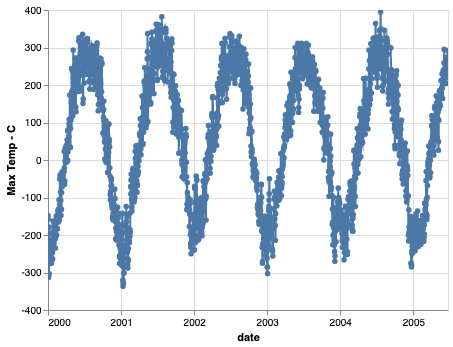

In [125]:
alt.Chart(daily_weather.head(2000).reset_index()).mark_line(point=True).encode(
    x=    alt.X('date:T',
        scale=alt.Scale(
            # domain=(20, 20),
            clamp=True
        )
    ),
    y=alt.X('TMAX:Q', title = "Max Temp - C")
).interactive()

In [97]:
weather[features].query(f"element in @elements")

,date,element,value
10,2001-05-17,TAVG,84.0
11,2001-06-30,TMIN,144.0
12,2001-08-06,TAVG,168.0
13,2001-09-04,TMAX,232.0
14,2001-10-31,TMAX,-1.0
...,...,...,...
23379,2018-10-03,TAVG,142.0
23380,2018-10-17,TAVG,3.0
23381,2018-10-12,TMIN,15.0
23382,2018-02-18,TAVG,-225.0


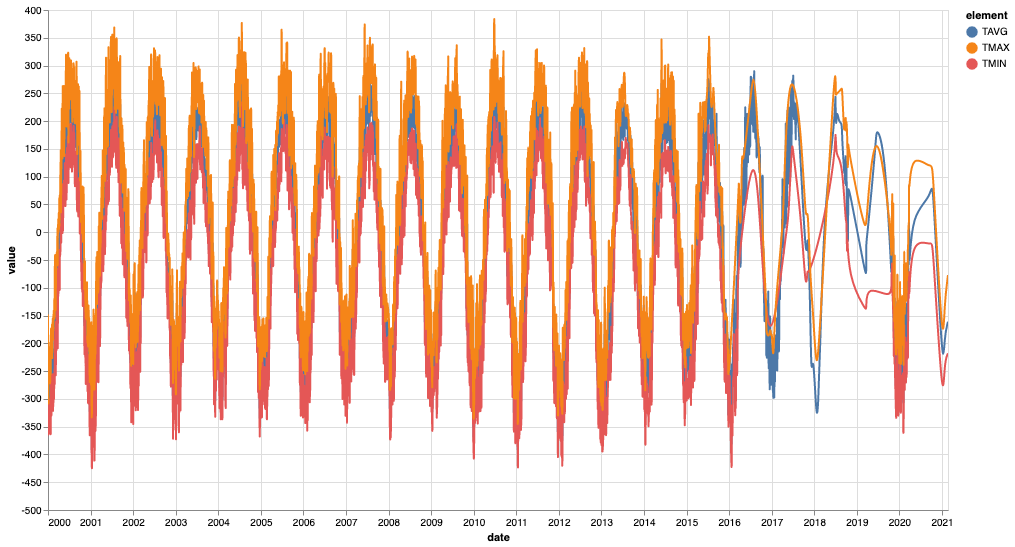

In [139]:
elements     = ['TMAX', 'TAVG', 'TMIN']
source = weather[features].query(f"element in @elements").copy()
resize = alt.selection_interval(bind='scales')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['date'], empty='none')

# The basic line
X_config = alt.X('date:T',
    scale = alt.Scale(clamp = True)
)
                 
line = alt.Chart(source).mark_line(interpolate='basis').encode(
    x     = X_config,
    y     = 'value:Q',
    color = 'element:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(source).mark_point().encode(
    x=X_config,
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'value:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(source).mark_rule(color='gray').encode(
    x=X_config,
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=900, height=500
).add_selection(resize).interactive()

### Principle Components Analysis

PCA creates orthogonal, uncorrelated vectors (linear combinations) that in sequence explains as much common variation as possible.  

- The first component will explain the most variance between all of the dimensions.  
- The 2nd component is orthoganal and explains the second most variance.
- If we had more components, successively they are also orthogonal to their previous component and explain less variance (of all dimensions) than the previous component.

The main application of PCA in this case will be for cluster analysis so reduction to a 2D visual space is the intended purpose.

> ## More details
>
> Check out Strang's concse 15minute explanation on SVD:  https://www.youtube.com/watch?v=mBcLRGuAFUk.  One of the most popular methods for calculating the PCA components is to calculate a pairwise covariance matrix, then apply SVD to it to get eigenvectors (the direction) and eigenvalues (the variance/magnitude of each original dimension) of the components.
>
> Unfamilliar jargon? A great refresher on linear algebra is **3 Blue 1 Brown's** series which is incredible to watch:  https://www.3blue1brown.com/essence-of-linear-algebra-page

#### Assumptions

- I expect temperature features to be mostly colinear in this dataset since they comprise the majority of data in this space.  
- Snowfall and percipitation are in different units than temperature variables.
- Transformation of all features to a common space will be necessary to accurately protect variance between each dimension.

#### Pre-processing transformation
- A lot of data isn't positive but aren't exactly normally distributed (for the most part).
- Log transformationn could be useful but would either need to square the temperature dimensions prior to PCA.

### Examining Co-linearity of Data
- Temperature, as expected, has homoscedastic pattern to itself (TMIN, TAVG, TMAX)
- Temperature to other variables (SNWD, PRCP) is more heteroskedastic in nature.
- Log-transformation may help the SNWD and PRCP dimensions with linearity.

The main goal of preprocessing is the help the clustering algorithms maximmize cohesion and separation (generally) but this is largely dependant on the clustering algorithm and distance metrics used.  Another method that's worth looking at is TSNE in place of PCA and likely won't be affected by colinearity/normal assumptions.


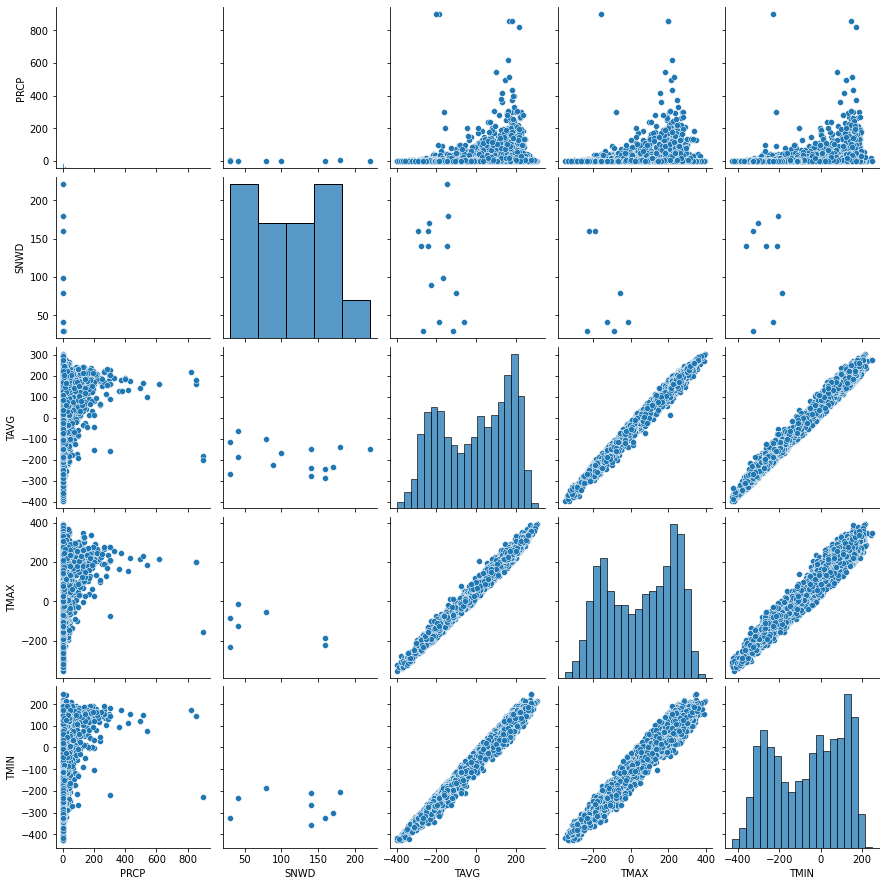

In [149]:
import seaborn as sns

sns.pairplot(daily_weather)

### Pushing temperature values to + space.

We could square the values, but I will first try $X = \lvert\min(X)\rvert + X$. 

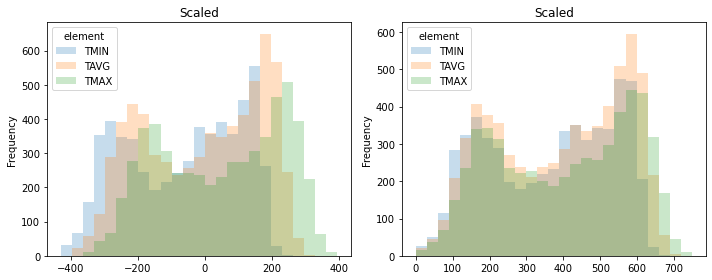

In [199]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

features = ['TMIN', 'TAVG', 'TMAX']
daily_weather[features].plot(kind = "hist", title = "Unscaled", alpha = .25, ax = ax[0], bins = 25)
(daily_weather[features].min() * -1 + daily_weather[features]).plot(kind = "hist", title = "Scaled", alpha = .25, ax = ax[1], bins = 25)

plt.tight_layout()

### Same Features$^2$

Scaling to this space may be useful but this approach maximimies the difference quite a bit (kind of like L1 vs L2).  If you're unfamilliar with this idea, check out:  https://www.quora.com/When-would-you-chose-L1-norm-over-L2-norm

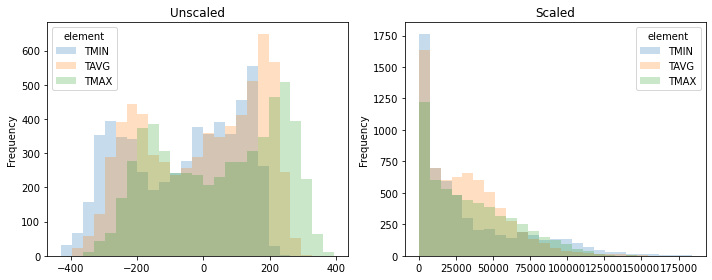

In [209]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

features = ['TMIN', 'TAVG', 'TMAX']
daily_weather[features].plot(kind = "hist", title = "Unscaled", alpha = .25, ax = ax[0], bins = 25)
(daily_weather[features] ** 2).plot(kind = "hist", title = "Scaled", alpha = .25, ax = ax[1], bins = 25)

plt.tight_layout()
plt.show()

### Actually apply the initial transformation

In [215]:
daily_weather.loc[:, [f"{f}_scaled" for f in features]] = (daily_weather[features].min() * -1 + daily_weather[features]).values
daily_weather.head()

element,PRCP,SNWD,TAVG,TMAX,TMIN,TMIN_scaled,TAVG_scaled,TMAX_scaled
date,,,,,,,,
2000-01-01,10.0,NaN,-197.0,-148.0,-290.0,139.0,199.0,205.0
2000-01-02,21.0,NaN,-213.0,-158.0,-282.0,147.0,183.0,195.0
2000-01-03,0.0,NaN,-310.0,-276.0,-336.0,93.0,86.0,77.0
2000-01-04,0.0,NaN,-340.0,-313.0,-369.0,60.0,56.0,40.0
2000-01-05,5.0,NaN,-338.0,-305.0,-361.0,68.0,58.0,48.0


### Apply the transformation

In [222]:
features = ['TMIN_scaled', 'TAVG_scaled', 'TMAX_scaled', 'PRCP', 'SNWD']
pca_data = daily_weather[features].fillna(0) # snow observations won't contribute that much, but adding them anywhere with 0 value

pca = PCA(n_components = 2)
pca.fit(pca_data)
X = pca.transform(pca_data)

array([-280.6788515 , -289.54093579, -443.88667765, ..., -389.42077991,
       -227.16152784, -170.19151454])

### Add Components to Original Dataset
Mainly for easy reference in tooltips.

In [230]:
daily_weather['C1'] = X[:, 0]
daily_weather['C2'] = X[:, 1]

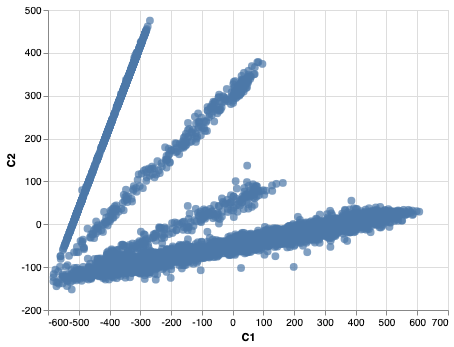

In [247]:

alt.Chart(daily_weather.reset_index()).mark_circle(size=60).encode(
    x='C1',
    y='C2',
    # color='Origin',
    tooltip=['date', 'C1', 'C2', 'TMIN', 'TAVG', 'TMAX', 'PRCP', 'SNWD']
).interactive()

### For this kind of data, "Density-based spatial clustering of applications with noise (DBSCAN)"

There are lots of clutsering methods.  The main goal of clustering is to apply a categorical grouping to similar groupings of points.  This is useful when examining what groups of points have in common for further investigation.

DBSCAN works great for the types of shapes seen in this component space which are contiguous shapes having similar density.

> For an intuitive explanation of this technique and how the parameters work, check out https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

In [251]:
daily_weather['cluster'].value_counts()

-1    6607
 0       7
 2       5
 1       5
Name: cluster, dtype: int64

In [284]:
daily_weather.reset_index()['date'].astype(str)

0       2000-01-01
1       2000-01-02
2       2000-01-03
3       2000-01-04
4       2000-01-05
           ...    
6619    2020-10-08
6620    2020-10-09
6621    2021-01-08
6622    2021-01-21
6623    2021-02-21
Name: date, Length: 6624, dtype: object

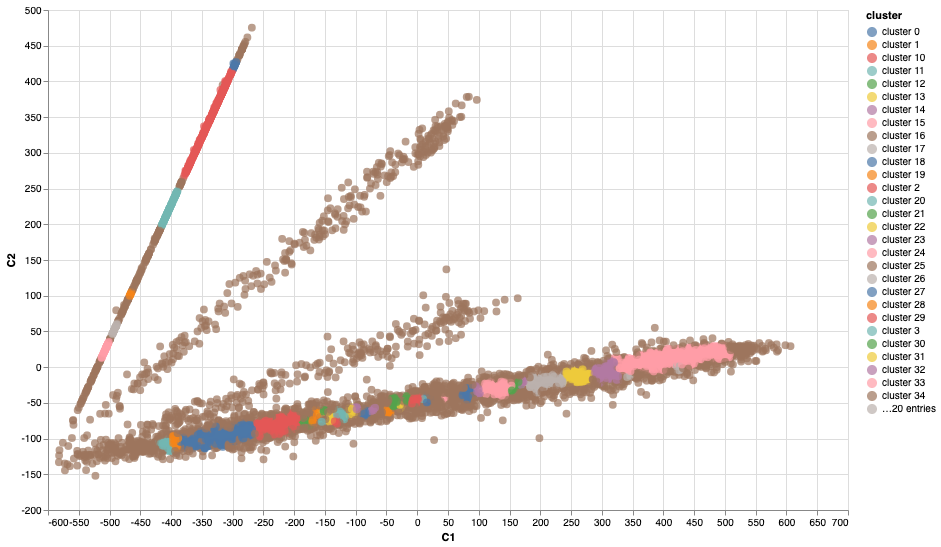

In [298]:
from sklearn.cluster import DBSCAN

## This is fast enough to run everytime.
dbs = DBSCAN(eps = 4, min_samples = 10, )
model = dbs.fit(X)
daily_weather['cluster'] = model.labels_ # unsupervised methods don't really have a .predict method like supervised methods so most of the parameters/cluster labels are stored in the instance object
daily_weather['cluster'] = daily_weather['cluster'].map(lambda n: 'none' if n == -1 else f"cluster {n}")

# date data encoding was working but trying as string now
daily_weather['date_str'] = daily_weather.index.map(lambda d: f"{d.month_name()} {d.day}, {d.year}")

alt.Chart(daily_weather).mark_circle(size=60).encode(
    x='C1',
    y='C2',
    color='cluster',
    tooltip=['cluster', 'date_str:N', 'C1', 'C2', 'TMIN', 'TAVG', 'TMAX', 'PRCP', 'SNWD']
).properties(width=800, height=500).interactive()


### Trying experimental clusteval library

I stumbled upon the `clusteval` package and it's kind of wonky.  I can reproduce this example using sklearn + gridsearch very likely using the same optimizers -- going to stay out of the weeds but for an intuitive explanation of the slhouette coefficient:  

# $sc(cluster) = \frac{separation(x_\text{ic})-cohesion(x_\text{ic})}{\max(separation(x_\text{ic}), cohesion(x_\text{ic}))}$

Where $x_\text{_ic}$ is a datapoint in each cluster.  Generally SC scores closer to 1 mean data is within a cohesive pattern, closer to 0  or -1 mean that clusters are more likely to overlap (poor quality).  This metric is kind of science fiction in my opinion and only useful for automated tuning if that. 

In [320]:
# !pip install clusteval

100%|██████████| 23/23 [00:11<00:00,  2.04it/s]


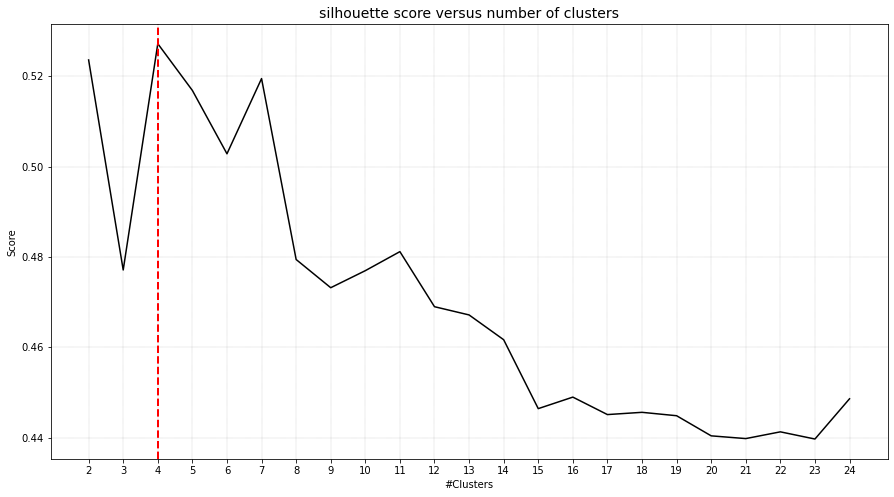

[clusteval] >Estimated number of n_clusters: 4, average silhouette_score=0.527


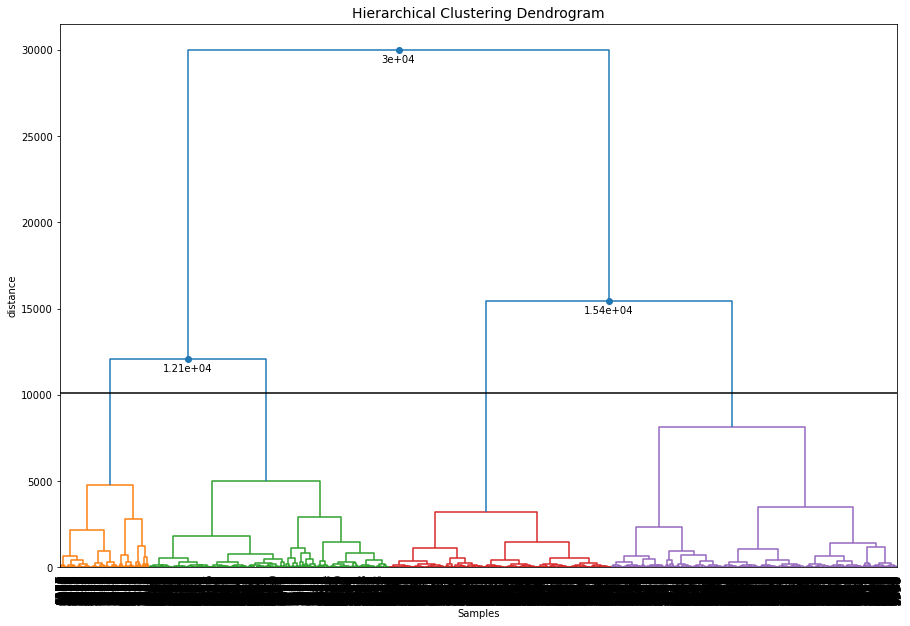

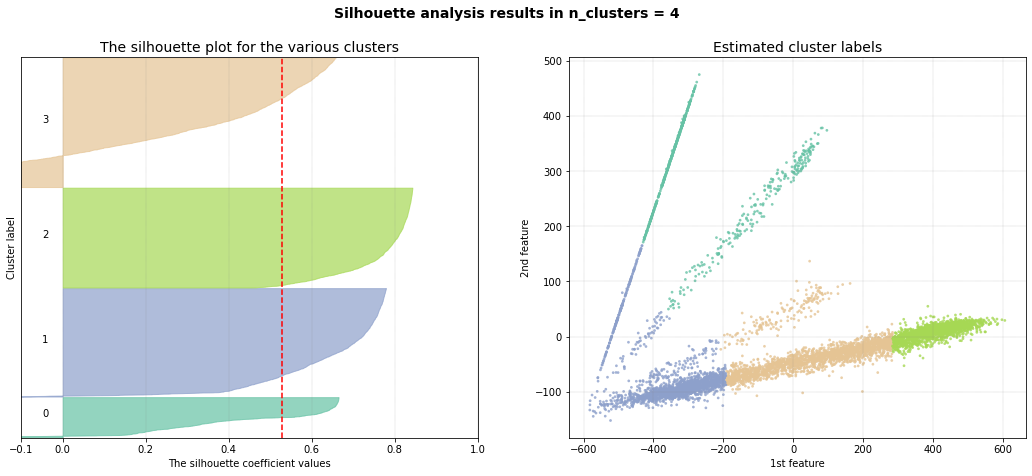

In [321]:
ce = clusteval(method='silhouette', verbose = 1)
ce.fit(X)
ce.plot()
ce.dendrogram()
ce.scatter(X)

### Attempting TSNE

-- will update soon but another alternative to PCA

> Be aware this is a time-intensive process.

In [333]:
%%time 
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)

daily_weather['tsne_C1'] = X_tsne[:, 0]
daily_weather['tsne_C2'] = X_tsne[:, 1]

CPU times: user 1min 21s, sys: 36.2 s, total: 1min 58s
Wall time: 19.1 s


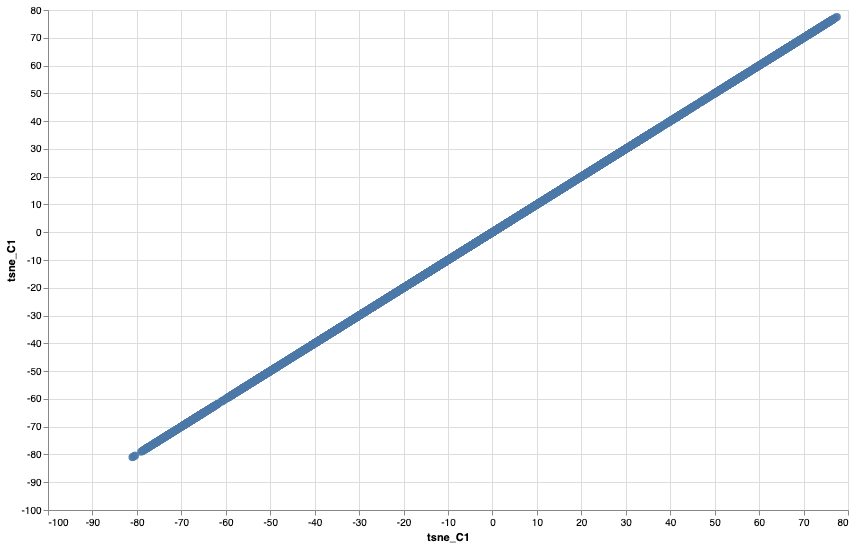

In [332]:
# date data encoding was working but trying as string now
daily_weather['date_str'] = daily_weather.index.map(lambda d: f"{d.month_name()} {d.day}, {d.year}")

alt.Chart(daily_weather).mark_circle(size=60).encode(
    x='tsne_C1',
    y='tsne_C1',
    # color='cluster',
    tooltip=['cluster', 'date_str:N', 'tsne_C1', 'tsne_C1', 'TMIN', 'TAVG', 'TMAX', 'PRCP', 'SNWD']
).properties(width=800, height=500).interactive()

### Total aside -- Interesting Seattle Weather Visuals

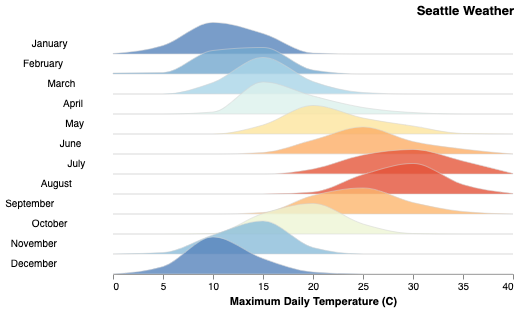

In [120]:
from vega_datasets import data
source = data.seattle_weather.url

step = 20
overlap = 1

alt.Chart(source, height=step).transform_timeunit(
    Month='month(date)'
).transform_joinaggregate(
    mean_temp='mean(temp_max)', groupby=['Month']
).transform_bin(
    ['bin_max', 'bin_min'], 'temp_max'
).transform_aggregate(
    value='count()', groupby=['Month', 'mean_temp', 'bin_min', 'bin_max']
).transform_impute(
    impute='value', groupby=['Month', 'mean_temp'], key='bin_min', value=0
).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('bin_min:Q', bin='binned', title='Maximum Daily Temperature (C)'),
    alt.Y(
        'value:Q',
        scale=alt.Scale(range=[step, -step * overlap]),
        axis=None
    ),
    alt.Fill(
        'mean_temp:Q',
        legend=None,
        scale=alt.Scale(domain=[30, 5], scheme='redyellowblue')
    )
).facet(
    row=alt.Row(
        'Month:T',
        title=None,
        header=alt.Header(labelAngle=0, labelAlign='right', format='%B')
    )
).properties(
    title='Seattle Weather',
    bounds='flush'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_title(
    anchor='end'
)

- These can be produced given categorical features

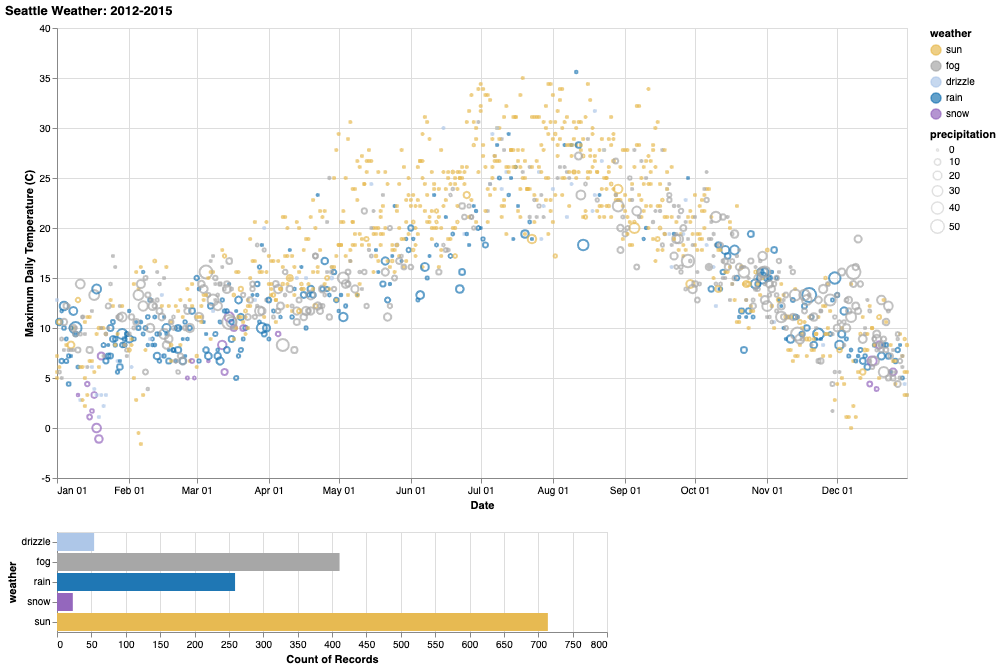

In [143]:
source = data.seattle_weather()

scale = alt.Scale(domain=['sun', 'fog', 'drizzle', 'rain', 'snow'],
                  range=['#e7ba52', '#a7a7a7', '#aec7e8', '#1f77b4', '#9467bd'])
color = alt.Color('weather:N', scale=scale)

# We create two selections:
# - a brush that is active on the top panel
# - a multi-click that is active on the bottom panel
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_point().encode(
    alt.X('monthdate(date):T', title='Date'),
    alt.Y('temp_max:Q',
        title='Maximum Daily Temperature (C)',
        scale=alt.Scale(domain=[-5, 40])
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    size=alt.Size('precipitation:Q', scale=alt.Scale(range=[5, 200]))
).properties(
    width=850,
    height=450
).add_selection(
    brush
).transform_filter(
    click
)

# Bottom panel is a bar chart of weather type
bars = alt.Chart().mark_bar().encode(
    x='count()',
    y='weather:N',
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=550,
).add_selection(
    click
)

alt.vconcat(
    points,
    bars,
    data=source,
    title="Seattle Weather: 2012-2015"
)